In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [23]:
import gc
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
# import timedelta
from datetime import datetime, timedelta
import lightgbm as lgb

# vizualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


In [3]:
#cdf from conditional quantile regression
def cqr_cdf(row, cdf_keyword): 
    #prob = betas.loc[:,('probabilities')].values
    #print(row)
    prob = row.index.values
    quantiles = row.values
    #quantiles[quantiles < 0] = 0
    #quantiles[quantiles > 1] = 1
    quantiles_extended = np.concatenate([[0], sorted(quantiles), [1]])
    probabilities_extended = np.concatenate([[0],prob,[1]])
    # if cdf_keyword == 'cdf':
    #     interpolation = IUS(quantiles_extended, probabilities_extended, bbox=[0, 1])
    # elif cdf_keyword == 'inv_cdf':
    #     interpolation = IUS(probabilities_extended, quantiles_extended)
    if cdf_keyword == 'cdf':
        interpolation = interp1d(quantiles_extended, probabilities_extended, bounds_error=False, fill_value=(0, 1))
    elif cdf_keyword == 'inv_cdf':
        interpolation = interp1d(probabilities_extended, quantiles_extended, bounds_error=False, fill_value=(0, 1))
    return interpolation

In [4]:
input_dir = './data/quantile/'
output_test = pd.read_csv(input_dir+'./year_qs_test.csv', index_col=0, parse_dates=[0])
# change all but last column names to float
output_test.columns = [float(x) if x != 'hour' else x for x in output_test.columns]
data_test = pd.read_csv('./data/extra_test.csv', index_col=0, parse_dates=['timestamp'])
y = data_test['net_target'].values
qts = np.concatenate([[0.001],np.arange(0.05,0.951,0.05),[0.999]])
features = ['Month', 'Hour', 'hour_x', 'hour_y', 'month_x', 'month_y',
'net_target-1', 'diffuse_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1']
target = 'net_target'

In [8]:
files

['.DS_Store', 'lag_minus_1', 'point', 'lag_minus_24']

In [9]:
# for each file in the folder models
# load the model
model_dir = './models/lag_minus_1/'
# names of the files
files = os.listdir(model_dir)
# sort filenames in mathematical order for numbers with decimal points after the underscore
files.sort(key=lambda f: float('.'.join(f.split('_')[1].split('.')[:-1])))
# load the lgb models in txt files
models = [lgb.Booster(model_file=model_dir+file) for file in files]

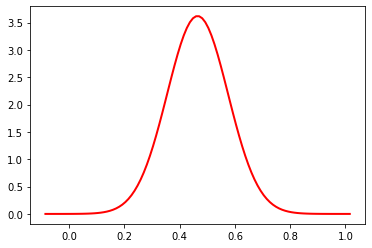

In [13]:
row = data_test.iloc[20]
qts_temp = {}
for i, qt in enumerate(qts):
    # load lgb model 
    model = models[i]
    # predict the quantile
    qts_temp['{}'.format(qt)] = model.predict(row[features].values.reshape(1,-1)).item(0)
    # 
qts_temp = pd.Series(data = list(qts_temp.values()), index = qts.round(3))
mu, std = norm.fit(qts_temp)

# Generate a range of x values for the plot
x = np.linspace(mu - 5*std, mu + 5*std, 100)

# Evaluate the PDF at each x value
y = norm.pdf(x, mu, std)

# Plot the PDF
plt.plot(x, y, 'r-', lw=2)
plt.show()

In [12]:
qts_temp

0.001    0.310481
0.050    0.369237
0.100    0.380590
0.150    0.392508
0.200    0.395841
0.250    0.407541
0.300    0.410353
0.350    0.412127
0.400    0.417983
0.450    0.426125
0.500    0.424063
0.550    0.435589
0.600    0.445733
0.650    0.449849
0.700    0.472793
0.750    0.479409
0.800    0.506465
0.850    0.540945
0.900    0.601305
0.950    0.663160
0.999    0.815909
dtype: float64

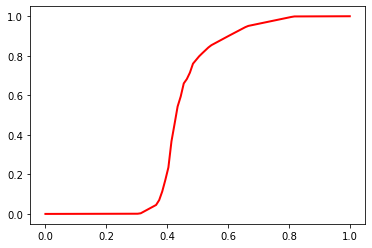

In [15]:
# fit a function to qts_temp.T
cdf = cqr_cdf(qts_temp, 'cdf')
# find a derivative of the function
inv_cdf = cqr_cdf(qts_temp, 'inv_cdf')
x = np.linspace(0, 1, 100)
# plot inv_cdf for a linspace
plt.plot(x, cdf(x), 'r-', lw=2)

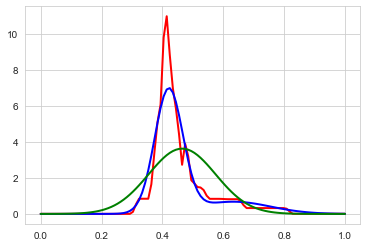

In [43]:
# calculate the derivative of the CDF to obtain an estimate of the PDF
dx = 0.01
pdf = np.gradient(cdf(x), dx)
plt.plot(x, pdf, 'r-', lw=2)
# fit a two-component Gaussian mixture model to the data
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(qts_temp.values.reshape(-1,1))
# generate a range of x values for the plot
x = np.linspace(0, 1, 100)
# evaluate the PDF at each x value
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'b-', lw=2)
mu, std = norm.fit(qts_temp)
# Evaluate the PDF at each x value
y = norm.pdf(x, mu, std)

# Plot the PDF
plt.plot(x, y, 'g-', lw=2)
plt.show()


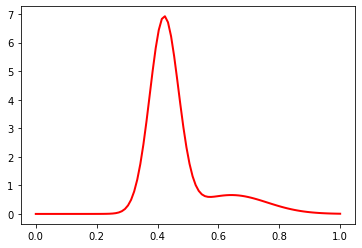

In [28]:
# fit a two-component Gaussian mixture model to the data
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(qts_temp.values.reshape(-1,1))
# generate a range of x values for the plot
x = np.linspace(0, 1, 100)
# evaluate the PDF at each x value
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'r-', lw=2)

In [31]:
def estimate_pdf(row):
    qts_temp = {}
    for i, qt in enumerate(qts):
        # load lgb model 
        model = models[i]
        # predict the quantile
        qts_temp['{}'.format(qt)] = model.predict(row[features].values.reshape(1,-1)).item(0)
        # 
    qts_temp = pd.Series(data = list(qts_temp.values()), index = qts.round(3))
    gmm = GaussianMixture(n_components=2, covariance_type='full').fit(qts_temp.values.reshape(-1,1))
    return gmm

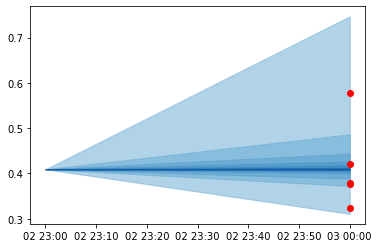

In [145]:
row = data_test.iloc[24]
pdf, qts_res = estimate_pdf(row)
dates = np.array([(row.timestamp - timedelta(hours=1)), row.timestamp])
init_v = row['net_target-1']
# make a list with a gradient of 10 colours from blue to dark blue
colors = sns.color_palette("Blues", 20)

# plt the confidence intervals between 0.05 and 0.95
plt.fill_between(dates, np.array([init_v, qts_res[0.001]]), np.array([init_v, qts_res[0.999]]), alpha=0.5, color=colors[10])
plt.fill_between(dates, np.array([init_v, qts_res[0.05]]), np.array([init_v, qts_res[0.95]]), alpha=0.5, color=colors[10])
plt.fill_between(dates, np.array([init_v, qts_res[0.1]]), np.array([init_v, qts_res[0.9]]), alpha=0.5, color=colors[11])
plt.fill_between(dates, np.array([init_v, qts_res[0.15]]), np.array([init_v, qts_res[0.85]]), alpha=0.5, color=colors[12])
plt.fill_between(dates, np.array([init_v, qts_res[0.2]]), np.array([init_v, qts_res[0.8]]), alpha=0.5, color=colors[13])
plt.fill_between(dates, np.array([init_v, qts_res[0.25]]), np.array([init_v, qts_res[0.75]]), alpha=0.5, color=colors[14])
plt.fill_between(dates, np.array([init_v, qts_res[0.3]]), np.array([init_v, qts_res[0.7]]), alpha=0.5, color=colors[15])
plt.fill_between(dates, np.array([init_v, qts_res[0.35]]), np.array([init_v, qts_res[0.65]]), alpha=0.5, color=colors[16])
plt.fill_between(dates, np.array([init_v, qts_res[0.4]]), np.array([init_v, qts_res[0.6]]), alpha=0.5, color=colors[17])
# sample 5 points from the pdf
samples = pdf.rvs(5)
# plot the samples
for sample in samples:
    plt.scatter(dates[1], sample, color='red')

In [38]:
sample_temp[0][0][0]

0.5547042588941372

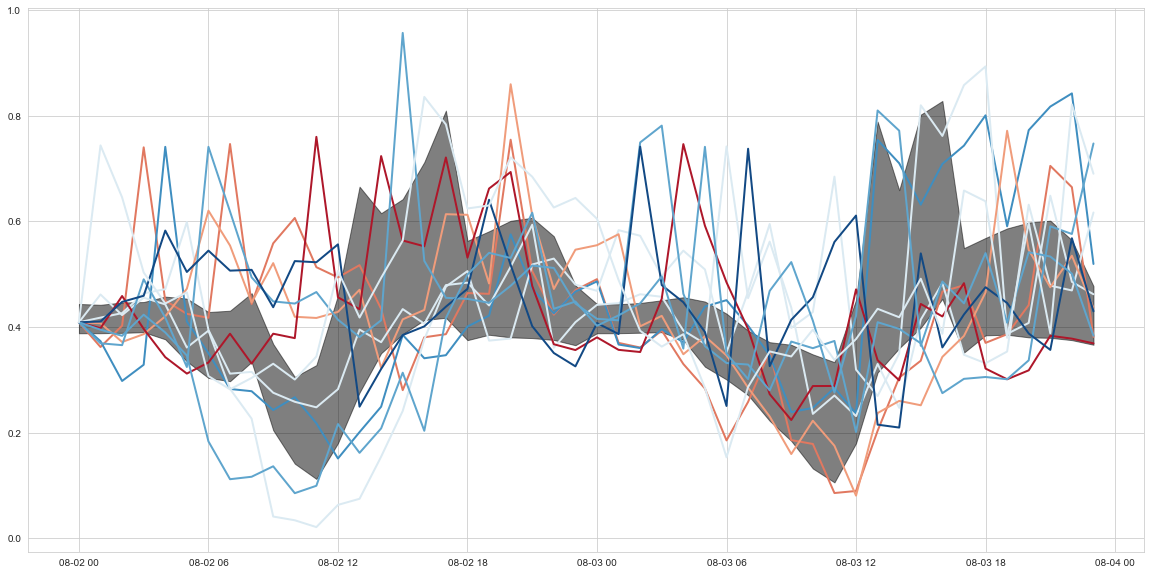

In [45]:
HORIZON = 48
# make colors a list of diverging and blunt colours
colors = sns.color_palette("RdBu_r", 20)
vls_dict = {}
fig, ax = plt.subplots(figsize=(20,10))
for j in range(10):
    dates = np.array([(data_test.iloc[1].timestamp - timedelta(hours=1))])
    init_v = data_test.iloc[0]['net_target-1']
    vls = np.array([init_v])
    for i, row in data_test.iloc[1:HORIZON, :].iterrows():    
        row['net_target-1'] = vls[-1]
        gmm = estimate_pdf(row)
        # sample 1 points from the pdf
        sample_temp = gmm.sample(1)[0][0][0]
        # append to an nparray
        dates = np.append(dates, row.timestamp)
        vls = np.append(vls, sample_temp)
    # pick a random colour
    color = colors[np.random.randint(0, 20)]
    # plot the samples with thicker lines in plotly
    ax.plot(dates, vls, color=color, linewidth=2)
# grid on
ax.grid(True)
# seaborn style
sns.set_style("whitegrid")
interval_df = output_test.loc[pd.to_datetime(dates)]
# fill prediciton intervals from 0.1 and 0.9 quantiles with black linecolor
ax.fill_between(dates, interval_df[0.1], interval_df[0.9], alpha=0.5, color='black')
plt.show()

In [165]:
pdf.rvs(size=5)

array([0.5238338 , 0.46979936, 0.68254008, 0.30419601, 0.4755641 ])

In [21]:
cdf = cqr_cdf(output.iloc[0,:-1], 'cdf')
x = np.linspace(-1,1,100)
pdf = np.gradient(cdf(x), x)

In [22]:
pdf

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.05514988e-04, 2.41654496e-03, 3.22205995e-03,
       3.22205995e-03, 3.22205995e-03, 3.22205995e-03, 3.22205995e-03,
      

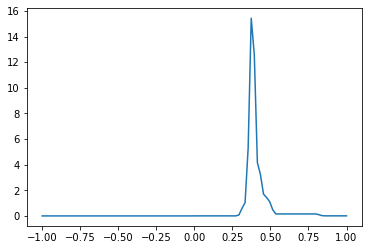

In [24]:
plt.plot(np.linspace(-1,1,100), pdf)

In [ ]:
class expando:
    pass 

class modelEstimation:
    def __init__(self, qs, data): 
        print('modelEstimation class initialized')
        print('Cooking up the cdf distributions')
        self._set_cdf(qs)
    def _set_cdf(self, data):
        self.cdf = expando()
        self.inv_cdf = expando()
        for leadT in data.hour.unique():
            cdf_loc_leadT = \
                lambda prediction, cdf_keyword='cdf': \
                cqr_cdf(prediction, cdf_keyword)
            setattr(self.cdf, str(leadT), cdf_loc_leadT)

            inv_cdf_loc_leadT = \
                lambda prediction, cdf_keyword='inv_cdf': \
                cqr_cdf(prediction, cdf_keyword)
            setattr(self.inv_cdf, str(leadT), inv_cdf_loc_leadT)
        pass
